# Facial Keypoint Detection

This notebook uses a Convolutional Neural Network (CNN) to perform facial keypoint detection. This study will show that a CNN can be trained to predict facial keypoint detection on any image. The network architecture, training process, and test validation will be covered. Finally, it will be shown that the keypoint locations can be used to overlay additional images on particular parts of the face. 

<img src='images/key_pts_example.png' width=50% height=50%/>

## Import Libraries

This study uses Pytorch to build and train the CNN network. Custom model, training classes have been created and are imported here. Helper functions for loading, transforming, and visualizing data are also imported. 

* model - contains Net class that defines the CNN network architecture and feedforward behavior
* trainer - contains Trainer class that defines the training behavior, including the loss and optimization functions
* helper - contains various utility functions for visualizing the data
* dataload - contains utility functions for loading and transforming the data set

In [16]:
import helper
from model import Net
from trainer import Trainer
from data_load import FacialKeypointsDataset, Rescale, RandomCrop, Normalize, ToTensor

from torchvision import transforms
from highcharts import Highchart
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

## Download data

Labelled training and test sets are downloaded and unzipped into the `/data` directory. 

In [ ]:
#Get labelled Facial Keypoint Data
URL = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/"
DATA_FILE = 'train-test-data.zip'
DOWNLOAD_PATH = './data/'


if not Path(DOWNLOAD_PATH).exists(): Path(DOWNLOAD_PATH).mkdir()

if not Path(DOWNLOAD_PATH, DATA_FILE).exists():
    print("Downloading data...")
    r = requests.get(URL + DATA_FILE, stream=True)
    assert(r.ok), 'Input data files could not be downloaded from URL'
    with open(str(Path(DOWNLOAD_PATH, DATA_FILE)), 'wb+') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk: f.write(chunk)

    z = zipfile.ZipFile(str(Path(DOWNLOAD_PATH, DATA_FILE)))
    z.extractall(DOWNLOAD_PATH)
    print("Downloading and extraction complete.")

## Prepare Data

Data loaders are created here so that batches of images can be fed into the CNN during training and testing. The training set and test set are a labelled set of 3462 images and 700 images, respectively. 

The CNN will expect the input images to be the size shape and size. The image resolution was  Image channels and keypoint data are normalized to be between 0 and 1 to speed up backpropagation during training. The following transformations will be applied to the images prior to training and testing:
* Grayscale - Grayscale images are used since color channels are not needed to detect facial keypoints. 
* Image rescale - Images are scaled up or down to be 100 x 100 pixels, a low resolution to speed up training. 
* Image crop - Crop image to be 96 x 96 pixels. 
* Normalize - Image channels and keypoint data are normalized to be between 0 and 1


In [51]:
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(100),RandomCrop(96),Normalize(),ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='./data/test/',
                                             transform=data_transform)

print('Number of train images: ', len(train_dataset))
print('Number of test images: ', len(test_dataset))

Number of train images:  3462
Number of test images:  770


Transformed image size:  96 x 96


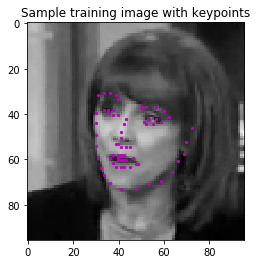

In [54]:
sample_id = 2
sample_set = train_dataset[sample_id]
sample_img = sample_set['image'].data.squeeze().numpy()
sample_pts = sample_set['keypoints'].data.numpy()
sample_pts = sample_pts*50+100 #Remove normalization from keypoints

print('Transformed image size: ', sample_img.shape[0], 'x', sample_img.shape[1])
helper.show_all_keypoints(sample_img, sample_pts)
plt.title('Sample training image with keypoints')
plt.show()

## CNN Architecture



In [10]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full1): Linear(in_features=6400, out_features=1000, bias=True)
  (dropout): Dropout(p=0.4)
  (full2): Linear(in_features=1000, out_features=136, bias=True)
)


## Train

In [ ]:
# Network hyperparams 
batch_size = 10
n_epochs = 10
lr = 0.001

run_dir = helper.create_training_dir()

#Attach network model to Trainer
trainer = Trainer(net, name="Training Run", root_dir=run_dir)

#Attach test and training data to Trainer
trainer.train_set(transformed_dataset, batch_size)
trainer.test_set(test_dataset, batch_size)

#Set loss function and optimizer
trainer.loss_fn(trainer.L1_SMOOTH)
trainer.optimizer(trainer.ADAM, lr=lr)

In [ ]:
trainer.train(n_epochs)

In [11]:
DIR = './train'

chart = helper.display_losses(DIR)
chart

## Run Tests